In [4]:
import cdo
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!cdo -select,season=JJAS sst.day.mean.2021.nc jjas40.nc

cdo select: Processed 126489600 values from 1 variable over 365 timesteps [2.41s 77MB]


In [5]:
perct=xr.open_dataset("/home/matin/project/major/code/project_mhw/verification/percentile40.nc")
perct2=xr.where(perct,perct.rolling(time=11).mean(),perct)
perct2.to_netcdf("perct2.nc")
!cdo -select,season=JJAS perct2.nc Percentilejjas.nc

cdo select: Processed 2440000 values from 1 variable over 365 timesteps [0.03s 256MB]


In [6]:
perct3=xr.open_dataset("/home/matin/project/major/code/project_mhw/verification/Percentilejjas.nc")
perct4=perct3.assign_coords({'time':perct3.time.dt.dayofyear})
perct4.to_netcdf("perct4.nc")

In [7]:
sst=xr.open_dataset("/home/matin/project/major/code/project_mhw/verification/jjas40.nc")
sst_40=sst.sst
dataset=sst_40.assign_coords({'time':sst.time.dt.dayofyear})
dataset.to_netcdf("dataset.nc")
dataset2=dataset.sel(lon=slice(50,100),lat=slice(0,25))
dataset2.to_netcdf("dataset2.nc")

In [8]:
!rm change.nc
!rm logic.nc
!cdo -s sub dataset2.nc perct4.nc change.nc  
!cdo -s gt dataset2.nc perct4.nc logic.nc 

Warning (splitTimevalue): Reset wrong date/time to 0000-01-01 00:00:00!
Warning (splitTimevalue): Reset wrong date/time to 0000-01-01 00:00:00!


In [9]:
change=xr.open_dataset("/home/matin/project/major/code/project_mhw/verification/change.nc")
change=change.assign_coords({'time':perct3.time.dt.dayofyear})
ch=change.sst[4:]

In [10]:
logic=xr.open_dataset("/home/matin/project/major/code/project_mhw/verification/logic.nc")
logic=logic.assign_coords({'time':perct3.time.dt.dayofyear})
lo=logic.sst[4:]

In [13]:

l=[]
for i in range(0,118):
    five_days=logic.sst[i:i+5].sum('time',skipna=False)
    l.append(xr.where(five_days<5,0,five_days).data)
fivexr6=xr.DataArray(np.array(l), coords=[("time",logic.time.data[4:]),("lat", logic.lat.data), ("lon", logic.lon.data)])

fivexr61=xr.where(fivexr6==5,1,fivexr6)


m=[]
for i in range(0,118):
    a=fivexr61[i:i+2].sum("time",skipna=False)
    m.append(xr.where(a>1,0,a).data)
fivexr62=xr.DataArray(np.array(m), coords=[("time",logic.time.data[4:]),("lat", logic.lat.data), ("lon", logic.lon.data)])


frqyr21=fivexr62.sum("time",skipna=False)
iyr21=xr.where(fivexr61==1,ch,fivexr61).sum("time",skipna=False)

!rm jjas40.nc
!rm perct2.nc
!rm Percentilejjas.nc
!rm perct4.nc
!rm dataset.nc
!rm dataset2.nc


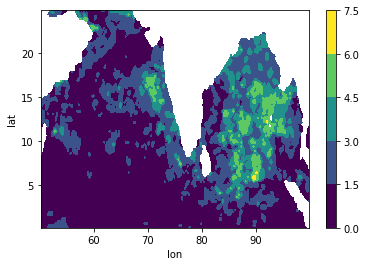

In [14]:

frqyr21=fivexr62.sum("time",skipna=False)
frequency=xr.where(frqyr21%2==0,frqyr21//2,(frqyr21+1)/2)
frequency.plot.contourf()
plt.savefig("frequency21.png")

/tmp/ipykernel_12027/2789169586.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "labels" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("cum_intes21.png", labels='Intensity')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


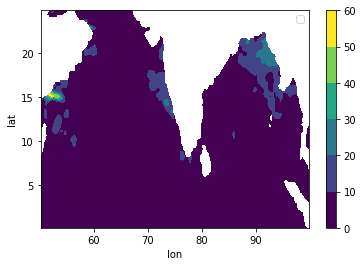

In [18]:
intensity=xr.where(fivexr61==1,ch,fivexr61).sum("time",skipna=False)
intensity.plot.contourf()
plt.savefig("cum_intes21.png", labels='Intensity')
plt.legend()

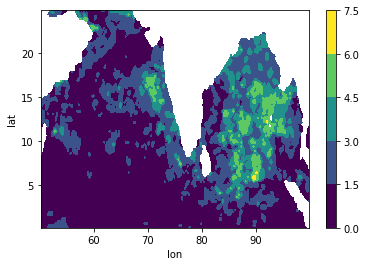

In [16]:
frequency=xr.where(frqyr21%2==0,frqyr21//2,(frqyr21+1)/2)
frequency.plot.contourf()

In [14]:
frequency.where(frequency==frequency.max(), drop=True).squeeze()

<xarray.DataArray (lat: 4, lon: 4)>
array([[ 7., nan, nan, nan],
       [ 7.,  7., nan, nan],
       [nan, nan,  7., nan],
       [nan, nan, nan,  7.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 5.625 5.875 6.375 12.12
  * lon      (lon) float32 89.62 89.88 90.12 92.12

In [41]:
dataset=xr.open_dataset("sst.day.mean.2021.nc")
percentile90=xr.open_dataset("percentile40.nc")

In [42]:
dataset2=dataset.sel(lon=slice(50,100),lat=slice(0,25))

dataset2.sst[:,22,158]

<xarray.DataArray 'sst' (time: 365)>
array([29.17, 29.23, 29.31, ..., 28.97, 28.93, 28.89], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
    lat      float32 5.625
    lon      float32 89.62
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  35.19]

In [43]:
import pandas as pd

In [44]:
##Converting Xarray Data into DataFrames and Concatening them
dataset2=dataset.sel(lon=slice(50,100),lat=slice(0,25))
rolling_mean=percentile90.rolling(time=11).mean()
SST=pd.DataFrame(dataset2.sst[:,22,158].astype(np.float32).data,index=pd.date_range("2021-01-01", periods=365),columns=['SST'])
NiNtypercentile=pd.DataFrame(rolling_mean.__xarray_dataarray_variable__[:,22,158].data,index=pd.date_range("2021-01-01", periods=365),columns=['90percentile'])

df=pd.concat([SST,NiNtypercentile],axis=1)
df

,SST,90percentile
2021-01-01,29.170000,NaN
2021-01-02,29.230000,NaN
2021-01-03,29.309999,NaN
2021-01-04,29.260000,NaN
2021-01-05,29.179998,NaN
...,...,...
2021-12-27,28.969999,29.064636
2021-12-28,28.959999,29.038454
2021-12-29,28.969999,29.026726
2021-12-30,28.930000,29.004999


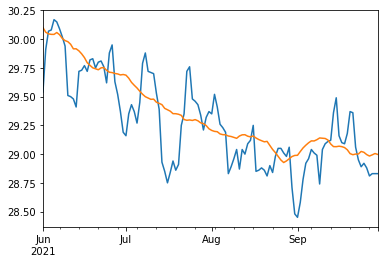

In [45]:
df['SST'][151:273].plot()
df['90percentile'][151:273].plot()
plt. savefig("time_series21.png")

In [46]:
da=df.where(df['SST']>df['90percentile'])
df=da[151:273]

In [47]:
print(df.to_markdown())

|                     |    SST |   90percentile |
|:--------------------|-------:|---------------:|
| 2021-06-01 00:00:00 | nan    |       nan      |
| 2021-06-02 00:00:00 | nan    |       nan      |
| 2021-06-03 00:00:00 |  30.07 |        30.0463 |
| 2021-06-04 00:00:00 |  30.08 |        30.0419 |
| 2021-06-05 00:00:00 |  30.17 |        30.0416 |
| 2021-06-06 00:00:00 |  30.15 |        30.058  |
| 2021-06-07 00:00:00 |  30.09 |        30.0389 |
| 2021-06-08 00:00:00 |  30.02 |        30.0061 |
| 2021-06-09 00:00:00 | nan    |       nan      |
| 2021-06-10 00:00:00 | nan    |       nan      |
| 2021-06-11 00:00:00 | nan    |       nan      |
| 2021-06-12 00:00:00 | nan    |       nan      |
| 2021-06-13 00:00:00 | nan    |       nan      |
| 2021-06-14 00:00:00 | nan    |       nan      |
| 2021-06-15 00:00:00 | nan    |       nan      |
| 2021-06-16 00:00:00 | nan    |       nan      |
| 2021-06-17 00:00:00 | nan    |       nan      |
| 2021-06-18 00:00:00 |  29.82 |        29.7725 |
